In [1]:
# !pip install quantstats
# TODO: Install TA-Lib
os.chdir("..")

In [1]:
from matplotlib import dates
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import talib.abstract as ta
import os
import time
import inspect


# from freqtrade.nbtools import IStrategy, BacktestEngine, FreqtradeDataset
qs.extend_pandas()
plt.style.use("seaborn")
MOUNT_DIR = "../freqtrade/mount"

os.getcwd()

'c:\\CS\\Python\\crypto-collection\\freqtrade-futures\\notebooks'

In [2]:
def plot_profits(trades_data, start, end):
    trades = trades_data.copy()
    start = pd.Timestamp(start, tz="UTC")
    if start < trades["open_date"].min():
        start = trades["open_date"].min()
    end = pd.Timestamp(end, tz="UTC")
    if end > trades["close_date"].max():
        end = trades["close_date"].max()
    
    # Section 1.1: BTC/USDT price over time
    btc_usdt_df = pd.read_json(f"{MOUNT_DIR}/data/binance/BTC_USDT-15m.json")
    btc_usdt_df.columns = ["date", "open", "high", "low", "close", "volume"]
    btc_usdt_df["date"] = pd.to_datetime(btc_usdt_df["date"], unit="ms", utc=True)
    btc_usdt = btc_usdt_df.loc[(btc_usdt_df["date"] >= start) & (btc_usdt_df["date"] <= end)]
    btc_usdt = btc_usdt.set_index("date").resample("1h").mean()
    fig, ax1 = plt.subplots(figsize=(18, 5))
    ax1.plot(btc_usdt["close"], color='orange', label="BTC/USDT")
    ax1.tick_params(axis='y', labelcolor='orange')

    # Section 1.2: Cumulative profit $ over time
    targetted_time_trades = trades.loc[(trades.open_date >= start) & (trades.close_date <= end)]
    targetted_time_trades = targetted_time_trades.set_index("close_date")
    profits_usd = targetted_time_trades.profit_abs.cumsum()
    ax2 = ax1.twinx()
    ax2.plot(profits_usd, color='green', label="Returns")
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    ax2.xaxis.set_major_locator(dates.MonthLocator(interval=1))
    ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
    ax2.xaxis.set_minor_locator(dates.AutoDateLocator())
    
    # Styloze and plot our section 1
    plt.title("BTC/USDT (orange), Returns in $ (green)")
    color = "white"
    ax1.grid(b=True, which='major', color=color, linestyle='-', axis="x", alpha=1)
    ax1.grid(b=True, which='minor', color=color, linestyle='-', axis="x", alpha=1)
    ax1.grid(b=True, which='major', color=color, linestyle='-', axis="y", alpha=1)
    ax2.grid(b=True, which='major', color=color, linestyle='-', axis="x", alpha=1)
    ax2.grid(b=True, which='minor', color=color, linestyle='-', axis="x", alpha=1)
    ax2.grid(b=True, which='both', color=color, linestyle='-', axis="y", alpha=1)
    ax1.grid(b=False, which='both', axis="y")
    plt.show()
        
    # Section 2: Create [left and right] plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
    
    # Section 2.1 Left: Profit $ with trades cumulative
    ax1.plot(list(trades.profit_abs.cumsum()), color="g")
    ax1.set_title("Trade $ returns")
    
    # Section 2.2 Right: Profit $ distribution histogram
    mean_profits = trades.profit_abs.mean()
    std_profits = trades.profit_abs.std()
    ax2.hist(trades.profit_abs.clip(mean_profits - 4*std_profits, mean_profits + 4*std_profits), bins=100)
    ax2.set_title("Returns $ distribution")
    plt.show()
    
    # Print Portfolio Summary
    print("Portfolio Summary")
    print("------------------------------")
    print("Min Balance          : %.2f" % min(profits_usd))
    print("Max Balance          : %.2f" % max(profits_usd))
    print("End Balance          : %.2f" % profits_usd[-1])
    print("------------------------------")
    print("Trades               : %i" % len(profits_usd))
    print("Avg. Profit $        : %.2f" % (profits_usd[-1] / len(profits_usd)))
    print("Biggest Profit $     : %.2f" % trades.profit_abs.max())
    print("Biggest Loss $       : %.2f" % trades.profit_abs.min())
    print("------------------------------")
    print("Sharpe               : %.2f" % trades.profit_abs.cumsum().pct_change().sharpe())
    # TODO: Max Drawdown, Return / Drawdown

In [5]:
def strategy_func():
    import talib as ta
    from freqtrade.nbtools import IStrategy

    def load_model():
        pass

    # Start Configure Strategy
    class MACrossover(IStrategy):
        minimal_roi = {"0": 0.02, "30": 0.01}
        stoploss = -0.01
        startup_candle_count: int = 0
        
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema_10"] = ta.EMA(dataframe["close"], timeperiod=10)
            dataframe["ema_20"] = ta.EMA(dataframe["close"], timeperiod=20)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe.loc[
                (
                    (dataframe['ema_10'] > dataframe['ema_20']) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe.loc[
                (
                    (dataframe['ema_10'] < dataframe['ema_20']) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'sell'] = 1
            return dataframe


# Start Configure Backtesting
# TODO: Assign preset name
btengine = BacktestEngine(
    dataset_path = f"{MOUNT_DIR}/data/binance",
    timeframe = "15m",
    timerange = "20210501-20210601",
    stake_amount = 15,
    initial_balance = 0,
    max_open_trades = 100,
    fee = 0.001,
    pairs = ["BTC/USDT", "ETH/USDT"]    
)
trades_data = btengine.start_backtest(MACrossover)
trades_data["profit_abs"].cumsum().plot()
# TODO: After BT finished, save results to cloud based storage.
print(inspect.getsource(strategy_func))

def strategy_func():
    import talib as ta
    from freqtrade.nbtools import IStrategy

    def load_model():
        pass

    # Start Configure Strategy
    class MACrossover(IStrategy):
        minimal_roi = {"0": 0.02, "30": 0.01}
        stoploss = -0.01
        startup_candle_count: int = 0
        
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema_10"] = ta.EMA(dataframe["close"], timeperiod=10)
            dataframe["ema_20"] = ta.EMA(dataframe["close"], timeperiod=20)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe.loc[
                (
                    (dataframe['ema_10'] > dataframe['ema_20']) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata:

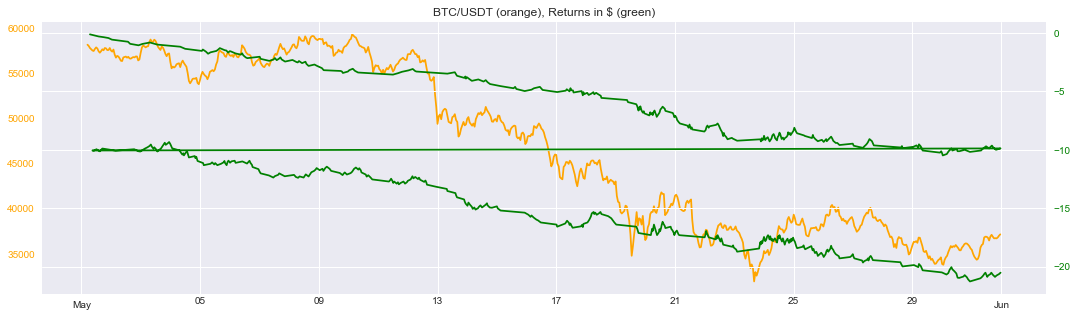

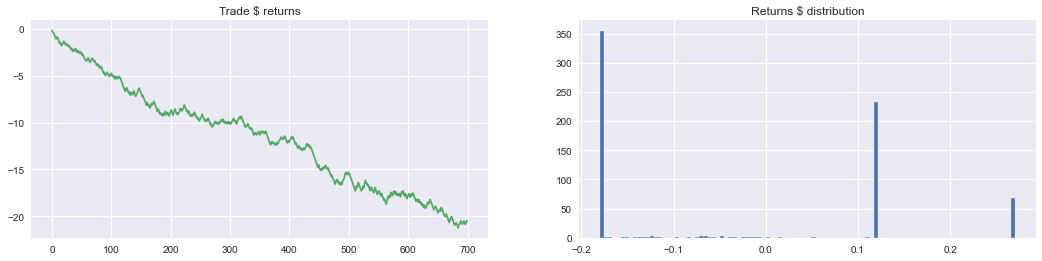

Portfolio Summary
------------------------------
Min Balance          : -21.26
Max Balance          : -0.12
End Balance          : -20.51
------------------------------
Trades               : 700
Avg. Profit $        : -0.03
Biggest Profit $     : 0.27
Biggest Loss $       : -0.18
------------------------------
Sharpe               : 2.07


In [6]:
# Plot profits here. TODO: In-notebook update function for historical data
timerange_start = "2021-05-01"
timerange_end = "2021-07-01"
plot_profits(trades_data, timerange_start, timerange_end)

In [7]:
trades_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   open_date     700 non-null    datetime64[ns, UTC]
 1   open_rate     700 non-null    float64            
 2   close_date    700 non-null    datetime64[ns, UTC]
 3   close_rate    700 non-null    float64            
 4   sell_reason   700 non-null    object             
 5   profit_ratio  700 non-null    float64            
 6   profit_abs    700 non-null    float64            
dtypes: datetime64[ns, UTC](2), float64(4), object(1)
memory usage: 38.4+ KB


In [8]:
# Access trades data dataframe
# ...